In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.9.0
numpy 1.26.4
pandas 2.2.2
sklearn 1.5.0
torch 2.3.1+cpu
cpu


In [2]:
#挂载谷歌云盘

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/transformer-de-en/* . -r

## 数据加载

- 采用WMT16的德语和英语平行语料库，数据集主页：[WMT16](https://www.statmt.org/wmt16/multimodal-task.html#task1)

In [2]:
#和jieba分词类似
!pip install sacremoses
# !pip install subword-nmt
# # BPE分词


Defaulting to user installation because normal site-packages is not writeable


ERROR: Invalid requirement: '#和jieba分词类似': Expected package name at the start of dependency specifier
    #和jieba分词类似
    ^

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!sh data_multi30k.sh wmt16 wmt16_cut de en

[train] 源语言文本分词完成
[train] 目标语言文本分词完成
[val] 源语言文本分词完成
[val] 目标语言文本分词完成
[test] 源语言文本分词完成
[test] 目标语言文本分词完成
Finished applying bpe to train files.
Finished applying bpe to val files.
Finished applying bpe to test files.



100%|##########| 10000/10000 [00:13<00:00, 747.18it/s]


Dataset

In [4]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader



class LangPairDataset(Dataset):

    def __init__(
        self, mode="train", max_length=128, overwrite_cache=False, data_dir="wmt16",
    ):
        self.data_dir = Path(data_dir)
        cache_path = self.data_dir / ".cache" / f"de2en_{mode}_{max_length}.npy"

        if overwrite_cache or not cache_path.exists():
            cache_path.parent.mkdir(parents=True, exist_ok=True)

            with open(self.data_dir / f"{mode}_src.bpe", "r", encoding="utf8") as file:
                self.src = file.readlines() # 读取源语言文件所有行

            with open(self.data_dir / f"{mode}_trg.bpe", "r", encoding="utf8") as file:
                self.trg = file.readlines() # 读取目标语言文件所有行

            filtered_src = []
            filtered_trg = []
            # max length filter,超出最大长度的句子舍弃
            for src, trg in zip(self.src, self.trg):
                if len(src) <= max_length and len(trg) <= max_length: # 过滤长度超过最大长度的句子
                    filtered_src.append(src.strip()) # 去掉句子前后的空格
                    filtered_trg.append(trg.strip())
            filtered_src = np.array(filtered_src)
            filtered_trg = np.array(filtered_trg)
            np.save(
                cache_path,
                {"src": filtered_src, "trg": filtered_trg },
                allow_pickle=True,
            )#allow_pickle=True允许保存对象数组，将过滤后的数据保存为 NumPy 数组，存储在缓存文件中
            print(f"save cache to {cache_path}")

        else:
            cache_dict = np.load(cache_path, allow_pickle=True).item() #allow_pickle=True允许保存对象数组
            print(f"load {mode} dataset from {cache_path}")
            filtered_src = cache_dict["src"]
            filtered_trg = cache_dict["trg"]

        self.src = filtered_src
        self.trg = filtered_trg

    def __getitem__(self, index):
        return self.src[index], self.trg[index]

    def __len__(self):
        return len(self.src)


train_ds = LangPairDataset("train")
val_ds = LangPairDataset("val")

save cache to wmt16\.cache\de2en_train_128.npy
save cache to wmt16\.cache\de2en_val_128.npy


In [7]:
# !rm wmt16/.cache -r

In [5]:
len(train_ds) #少了1000多个样本

27659

In [6]:
print("source: {}\ntarget: {}".format(*train_ds[-1]))

source: ein älterer mann sitzt mit einem jungen mit einem wagen vor einer fassade .
target: an elderly man sits outside a storefront accompani@@ ed by a young boy with a cart .


### Tokenizer

这里有两种处理方式，分别对应着 encoder 和 decoder 的 word embedding 是否共享，这里实现共享的方案

In [7]:
#载入词表，看下词表长度，词表就像英语字典,构建word2idx和idx2word
word2idx = {
    "[PAD]": 0,     # 填充 token
    "[BOS]": 1,     # begin of sentence
    "[UNK]": 2,     # 未知 token
    "[EOS]": 3,     # end of sentence
}
idx2word = {value: key for key, value in word2idx.items()}
index = len(idx2word)
threshold = 1  # 出现次数低于此的token舍弃

with open("wmt16/vocab", "r", encoding="utf8") as file:
    for line in tqdm(file.readlines()):
        token, counts = line.strip().split()
        if int(counts) >= threshold:
            word2idx[token] = index
            idx2word[index] = token
            index += 1

vocab_size = len(word2idx)
print("vocab_size: {}".format(vocab_size))

  0%|          | 0/9714 [00:00<?, ?it/s]

vocab_size: 9718


In [9]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=128, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """如果padding_first == True，则padding加载前面，否则加载后面"""
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))
        indices_list = []
        for text in text_list:
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]]
            if add_bos:
                indices = [self.bos_idx] + indices
            if add_eos:
                indices = indices + [self.eos_idx]
            if padding_first:
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)
        input_ids = torch.tensor(indices_list)
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64) # 为了方便损失计算，这里的mask为0的地方需要计算，为1的地方不需要计算
        return input_ids if not return_mask else (input_ids, masks)


    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text)
        return text_list


tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)

tokenizer.encode([["hello"], ["hello", "world"]], add_bos=True, add_eos=False)
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text, padding_first=False, add_bos=True, add_eos=True)
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("raw text")
for raw in raw_text:
    print(raw)
print("indices")
for index in indices:
    print(index)
print("decode text")
for decode in decode_text:
    print(decode)

raw text
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
indices
tensor([   1,    2, 4517,    3,    0,    0,    0])
tensor([   1,    2, 7167,    2,   22,    2,    3])
tensor([   1,  425,   18,    5, 4493,    3,    0])
decode text
[BOS] [UNK] world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with [UNK] [EOS]
[BOS] this is a test [EOS] [PAD]


In [12]:
for i,j in train_ds:
    print(len(i))
    print(len(j))
    break

72
54


### Transformer Batch Sampler

> Sentence pairs were batched together by approximate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens
句子按照序列长度差不多的分到一个批次。 每个训练批次包含一组句子对，其中包含大约 25000 个源标记和 25000 个目标标记

In [16]:
class SampleInfo: #下面的info对象
    def __init__(self, i, lens):
        """
        记录文本对的序号和长度信息
        输入：
            - i (int): 文本对的序号。
            - lens (list): 文本对源语言和目标语言的长度
        """
        self.i = i
        # 加一是考虑填补在文本前后的特殊词元，lens[0]和lens[1]分别表示源语言和目标语言的长度
        self.max_len = max(lens[0], lens[1]) + 1
        self.src_len = lens[0] + 1
        self.trg_len = lens[1] + 1

# 一个批量生成器，根据词元数目的限制来控制批量的大小。它会根据传入的样本信息，在不超过设定大小的情况下，逐步构建批量。
class TokenBatchCreator:
    def __init__(self, batch_size):
        """
        参数:
        batch_size (int): 用于限制批量的大小。
        功能:
        初始化了一个空的批量列表 _batch。
        设定了初始的最大长度为 -1。
        存储了传入的 batch_size。
        """

        self._batch = []  #这个就是之前的batch_size，就是第一个batch内有多少个样本
        self.max_len = -1
        self._batch_size = batch_size # 限制批量的大小,假设是4096

    def append(self, info):
        """
        参数:
        info (SampleInfo): 文本对的信息。
        功能:
        接收一个 SampleInfo 对象，并根据其最大长度信息更新当前批量的最大长度。
        如果将新的样本加入批量后超过了批量大小限制，它会返回已有的批量并将新的样本加入新的批量。
        否则，它会更新最大长度并将样本添加到当前批量中。
        """
        # 更新当前批量的最大长度
        cur_len = info.max_len # 当前样本的长度
        max_len = max(self.max_len, cur_len) # 每来一个样本，更新当前批次的最大长度
        # 如果新的样本加入批量后超过大小限制，则将已有的批量返回，新的样本加入新的批量
        if max_len * (len(self._batch) + 1) > self._batch_size:
            self._batch, result = [], self._batch # 保存当前的batch，并返回,这里的result是之前的batch,_batch清空
            self._batch.append(info) #箱子里的第一条样本，放入
            self.max_len = cur_len #因为是当前batch的第一个样本，所以它的长度就是当前长度
            return result
        else:
            self.max_len = max_len
            self._batch.append(info) # 将样本添加到当前批量中
            return None

    @property
    def batch(self):
        return self._batch

In [24]:
from torch.utils.data import BatchSampler
import numpy as np


class TransformerBatchSampler(BatchSampler):
    def __init__(self,
                 dataset,
                 batch_size,
                 shuffle_batch=False,
                 clip_last_batch=False,
                 seed=0):
        """
        批量采样器
        输入:
            - dataset: 数据集
            - batch_size: 批量大小
            - shuffle_batch: 是否对生成的批量进行洗牌
            - clip_last_batch: 是否裁剪最后剩下的数据
            - seed: 随机数种子
        """
        self._dataset = dataset
        self._batch_size = batch_size
        self._shuffle_batch = shuffle_batch
        self._clip_last_batch = clip_last_batch
        self._seed = seed
        self._random = np.random
        self._random.seed(seed)

        self._sample_infos = []
        # 根据数据集中的每个样本，创建了对应的 SampleInfo 对象，包含了样本的索引和长度信息。
        for i, data in enumerate(self._dataset):
            lens = [len(data[0]), len(data[1])] #输入和输出的长度计算放到lens中
            self._sample_infos.append(SampleInfo(i, lens))

    def __iter__(self):
        """
        对数据集中的样本进行排序，排序规则是先按源语言长度排序，如果相同则按目标语言长度排序。
        使用 TokenBatchCreator 逐步组装批量数据，当满足批量大小时返回一个批量的样本信息。
        如果不裁剪最后一个批次的数据且存在剩余样本，则将这些样本组成最后一个批次。
        如果需要对批量进行洗牌，则对批次进行洗牌操作。
        通过迭代器，抛出每个批量的样本在数据集中的索引。
        """
        # 排序，如果源语言长度相同则按照目标语言的长度排列
        infos = sorted(self._sample_infos,
                       key=lambda x: (x.src_len, x.trg_len))
        # 组装批量，所有的batch都放入batch_infos
        batch_infos = []
        batch_creator = TokenBatchCreator(self._batch_size) # 批量生成器
        for info in infos:
            batch = batch_creator.append(info)
            # 存够一个batch的样本信息后，会把这个batch返回，否则返回为None
            if batch is not None:
                batch_infos.append(batch)

        # 是否抛弃最后批量的文本对
        if not self._clip_last_batch and len(batch_creator.batch) != 0:
            batch_infos.append(batch_creator.batch) # 最后一个batch

        # 打乱batch
        if self._shuffle_batch:
            self._random.shuffle(batch_infos)

        self.batch_number = len(batch_infos)
        # print(self.batch_number) #为了理解

        # 抛出一个批量的文本对在数据集中的序号
        for batch in batch_infos:
            batch_indices = [info.i for info in batch] # 批量的样本在数据集中的索引，第一个batch[0,1,.....82]，第二个batch[83,84,85,86,87]
            yield batch_indices

    def __len__(self):
        """
        返回批量的数量
        """
        if hasattr(self, "batch_number"):
            return self.batch_number
        # 计算批量的数量,没有用到下面的情况，不用看
        batch_number = (len(self._dataset) +
                        self._batch_size) // self._batch_size
        return batch_number

In [25]:
sampler = TransformerBatchSampler(train_ds, batch_size=4096, shuffle_batch=True)

#为什么这里每个批量的样本对数目不一样呢？长度*batch_number>4096的时候，就会返回上一个batch，然后新的样本加入新的batch,具体要看TokenBatchCreator的44行

In [22]:
for idx, batch in enumerate(sampler):
    print("第{}批量的数据中含有文本对是：{}，数量为：{}".format(idx, batch, len(batch)))
    if idx >= 3:
        break

533
第0批量的数据中含有文本对是：[20303, 272, 3549, 11130, 12595, 12784, 13559, 22464, 1474, 6750, 7174, 8451, 10507, 15759, 16727, 19970, 25362, 27342, 27467, 2093, 2953, 3053, 4811, 6859, 10441, 10853, 11970, 15839, 16938, 18233, 20382, 21262, 24568, 14, 1067, 4934, 10278, 11027, 11753, 12988, 15029, 15900, 16219, 16799, 19208, 20018, 21926, 2490, 2565, 2854, 3903, 6469, 8006, 9892, 10241, 10400, 11697, 13678, 17015, 19819, 20660, 23208, 25640, 4620, 5719, 7807, 9474, 11360, 11423, 11857, 12519, 14495, 16832, 17204, 17214, 22914, 23865, 25037, 26610, 27438, 365, 1063, 3404]，数量为：83
第1批量的数据中含有文本对是：[1896, 2650, 5347, 6855, 13019, 14422, 15533, 17704, 20935, 21794, 27107, 2422, 5213, 6555, 6638, 7682, 7902, 14492, 19817, 20186, 20941, 21052, 21164, 21222, 23422, 23573, 23834, 24516, 24599, 528, 933, 5364, 7649, 8029, 12179, 16073, 17508, 17732, 20361, 21449, 25890, 26193, 26438, 1469, 5758, 9238, 10232, 16510, 17373]，数量为：49
第2批量的数据中含有文本对是：[6311, 19570, 21049, 21560, 24196, 24600, 12012, 12977, 23611, 

In [23]:
len(sampler)

533

### DataLoader

In [26]:
def collate_fct(batch, tokenizer):
    src_words = [pair[0].split() for pair in batch]
    trg_words = [pair[1].split() for pair in batch]

    # [BOS] src [EOS] [PAD]
    encoder_inputs, encoder_inputs_mask = tokenizer.encode(
        src_words, padding_first=False, add_bos=True, add_eos=True, return_mask=True
        )

    # [BOS] trg [PAD]
    decoder_inputs = tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False,
        )

    # trg [EOS] [PAD]
    decoder_labels, decoder_labels_mask = tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
        )

    return {
        "encoder_inputs": encoder_inputs.to(device=device),
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),
        "decoder_inputs": decoder_inputs.to(device=device),
        "decoder_labels": decoder_labels.to(device=device),
        "decoder_labels_mask": decoder_labels_mask.to(device=device),
    }


In [27]:
from functools import partial # 固定collate_fct的tokenizer参数

#可以调整batch_size,来看最终的bleu
sampler = TransformerBatchSampler(train_ds, batch_size=256, shuffle_batch=True)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
sample_dl = DataLoader(train_ds, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer)) #partial函数，固定collate_fct的tokenizer参数

for batch in sample_dl:
    for key, value in batch.items():
        print(key)
        print(value)
    break

encoder_inputs
tensor([[   1,    7,   17,    6,    8,   89,  157,   73,    7,  541,  255,    9,
           14,   42,  153,  119, 1481,  406, 2384, 1319,    4,    3],
        [   1,  521,    6,    8,  808, 1299, 2305, 1638, 2535,  184,   31, 1735,
          961,   55, 1732,    4,    3,    0,    0,    0,    0,    0]])
encoder_inputs_mask
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]])
decoder_inputs
tensor([[   1,    5,   16,    6,    5,   50,   41,   18,   78,    5,  421,  254,
         7050,  106,  471,    4],
        [   1,  452,    6,    5, 5010, 1118, 1010,  106,    5,  517, 5103,    4,
            0,    0,    0,    0]])
decoder_labels
tensor([[   5,   16,    6,    5,   50,   41,   18,   78,    5,  421,  254, 7050,
          106,  471,    4,    3],
        [ 452,    6,    5, 5010, 1118, 1010,  106,    5,  517, 5103,    4,    3,
            0,    0,    0,    0]])
decoder_labels_ma

## 定义模型

- Transformer模型由Embedding、Transformer-Block组成
- Embedding包括：
    - WordEmbedding
    - PositionEmbedding
- Transformer-Block包括：
    - Self-Attention
    - Cross-Attention
    - MLP

### Embedding

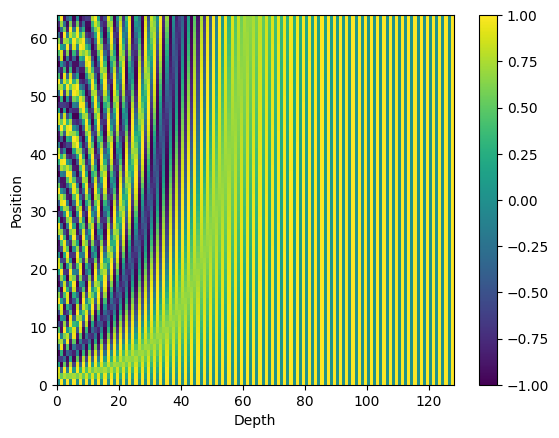

In [32]:

class TransformerEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.vocab_size = config["vocab_size"]
        self.hidden_size = config["d_model"] # 词向量维度
        self.pad_idx = config["pad_idx"]
        dropout_rate = config["dropout"]
        self.max_length = config["max_length"]

        # layers,设置padding_idx可以让pad的词向量全为0
        self.word_embedding = nn.Embedding(
            self.vocab_size, self.hidden_size, padding_idx=self.pad_idx
        )
        self.pos_embedding = nn.Embedding(
            self.max_length,
            self.hidden_size,
            _weight=self.get_positional_encoding(
                self.max_length, self.hidden_size
            ),# 位置编码，权重通过get_positional_encoding函数计算得到
        )
        self.pos_embedding.weight.requires_grad_(False) # 不更新位置编码的权重
        self.dropout = nn.Dropout(dropout_rate) # 随机失活层

    def get_word_embedding_weights(self):
        return self.word_embedding.weight

    # 计算位置信息
    @classmethod
    def get_positional_encoding(self, max_length, hidden_size):#max_length是最大长度，hidden_size是embedding维度相等
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_length, hidden_size) # 初始化位置编码
        # .unsqueeze(1) 是将这个一维张量转换为二维张量，即将其形状从 (max_length,) 变为 (max_length, 1)。这个操作在张量的维度上增加了一个维度，使其从一维变为二维，第二维的大小为 1。
        position = torch.arange(0, max_length).unsqueeze(1) # 位置信息,从0到max_length-1
        div_term = torch.exp(
            torch.arange(0, hidden_size, 2)
            * -(torch.log(torch.Tensor([10000.0])) / hidden_size)
        )# 计算位置编码的权重,为了性能考量（是数学上的对数函数分解）
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, input_ids):
        # input_ids: [batch_size, seq_len]
        seq_len = input_ids.shape[1]
        assert (
            seq_len <= self.max_length
        ), f"input sequence length should no more than {self.max_length} but got {seq_len}"

        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        print(position_ids)
        # embedding
        word_embeds = self.word_embedding(input_ids) # 词嵌入
        pos_embeds = self.pos_embedding(position_ids) # 位置编码
        embeds = word_embeds + pos_embeds
        embeds = self.dropout(embeds)

        return embeds


def plot_position_embedding(position_embedding):# 绘制位置编码
    plt.pcolormesh(position_embedding) # 绘制位置编码矩阵
    plt.xlabel('Depth')
    plt.ylabel('Position')
    plt.colorbar() # 颜色条，-1到1的颜色范围
    plt.show()

position_embedding = TransformerEmbedding.get_positional_encoding(64, 128)
plot_position_embedding(position_embedding)


In [33]:
#随机input，调用TransformerEmbedding
config={
    "vocab_size": 100,
    "d_model": 128,
    "pad_idx": 0,
    "max_length": 64,
    "dropout": 0.1,
}
input_ids = torch.randint(0, 100, (2, 50))
embeds = TransformerEmbedding(config)(input_ids)
embeds.shape

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])


torch.Size([2, 50, 128])

### Transformer Block

#### scaled-dot-product-attention

In [36]:
from dataclasses import dataclass
from typing import Optional, Tuple

Tensor = torch.Tensor

@dataclass
class AttentionOutput:
    hidden_states: Tensor
    attn_scores: Tensor

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.hidden_size = config["d_model"] # 隐藏层大小
        self.num_heads = config["num_heads"] # 多头注意力的头数
        assert (
            self.hidden_size % self.num_heads == 0
        ), "Hidden size must be divisible by num_heads but got {} and {}".format(
            self.hidden_size, self.num_heads
        )
        self.head_dim = self.hidden_size // self.num_heads # 每个头的维度

        # layers
        self.Wq = nn.Linear(self.hidden_size, self.hidden_size, bias=False) #第二个self.hidden_size可以*系数
        self.Wk = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wv = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wo = nn.Linear(self.hidden_size, self.hidden_size, bias=False) # 输出层

    def _split_heads(self, x: Tensor) -> Tensor:
        bs, seq_len, _ = x.shape #假设输入的维度是[batch_size, seq_len, hidden_size],hidden_size是512
        x = x.view(bs, seq_len, self.num_heads, self.head_dim) #num_heads是8，head_dim是64
        return x.permute(0, 2, 1, 3) #变换维度，[batch_size, num_heads, seq_len, head_dim]

    def _merge_heads(self, x: Tensor) -> Tensor:#将多头注意力的输出合并为一个张量
        bs, _, seq_len, _ = x.shape #假设输入的维度是[batch_size, num_heads, seq_len, head_dim]
        return x.permute(0, 2, 1, 3).reshape(bs, seq_len, self.hidden_size) # 变换维度，变为[batch_size, seq_len, hidden_size]

    def forward(self, querys, keys, values, attn_mask=None) -> AttentionOutput:
        # split heads
        querys = self._split_heads(self.Wq(querys)) #(batch_size, seq_len,hidden_dim)-->[batch_size, num_heads, seq_len, head_dim]
        keys = self._split_heads(self.Wk(keys))#[batch_size, num_heads, seq_len, head_dim]
        values = self._split_heads(self.Wv(values))#[batch_size, num_heads, seq_len, head_dim]

        # calculate attention scores
        qk_logits = torch.matmul(querys, keys.mT) # 计算注意力分数，matmul是矩阵乘法，mT是矩阵转置,qk_logits是[batch_size, num_heads, seq_len, seq_len]
        # print(querys.shape[-2], keys.shape[-2])  #3 4
        if attn_mask is not None:
            attn_mask = attn_mask[:, :, : querys.shape[-2], : keys.shape[-2]]
            qk_logits += attn_mask * -1e9 # 给需要mask的地方设置一个负无穷
        attn_scores = F.softmax(qk_logits / (self.head_dim**0.5), dim=-1) # 计算注意力分数

        # apply attention scores
        embeds = torch.matmul(attn_scores, values) # softmax后的结果与value相乘，得到新的表示
        embeds = self.Wo(self._merge_heads(embeds)) # 输出层 [batch_size, seq_len, hidden_size]

        return AttentionOutput(hidden_states=embeds, attn_scores=attn_scores)

mha = MultiHeadAttention({"num_heads": 2, "d_model": 2})
query = torch.randn(2, 3, 2) # [batch_size, seq_len, hidden_size]
query /= query.norm(dim=-1, keepdim=True) # 归一化
key_value = torch.randn(2, 4, 2)
print(f'key_value.shape {key_value.shape}')
outputs = mha(query, key_value, key_value) #最终输出shape和query的shape一样
print(outputs.hidden_states.shape)
print(outputs.attn_scores.shape)

key_value.shape torch.Size([2, 4, 2])
torch.Size([2, 3, 2])
torch.Size([2, 2, 3, 4])


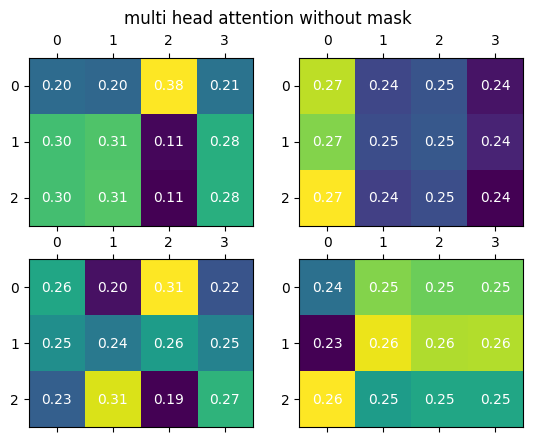

In [37]:
# plt.subplots() 用于创建子图网格，其维度基于 outputs.attn_scores.shape[:2]。子图的行数和列数似乎由 outputs.attn_scores 的前两个维度确定。
fig, axis = plt.subplots(*outputs.attn_scores.shape[:2])
for i in range(query.shape[0]):
    for j in range(outputs.attn_scores.shape[1]):
        # axis[i, j].matshow(outputs.attn_scores[i, j].detach().numpy())：此行使用 Matplotlib 的 matshow 绘制每个 i 和 j 的注意力分数热图。detach().numpy() 将 PyTorch 张量转换为 NumPy 数组以进行可视化。
        axis[i, j].matshow(outputs.attn_scores[i, j].detach().numpy())
        for x in range(outputs.attn_scores.shape[2]):
            for y in range(outputs.attn_scores.shape[3]):
                # axis[i, j].text(y, x, f"{outputs.attn_scores[i, j, x, y]:.2f}", ha="center", va="center", color="w")：此代码在热图上叠加文本，显示 (x, y) 位置处的注意力分数。格式化部分 f"{outputs.attn_scores[i, j, x, y]:.2f}" 确保以两位小数显示注意力分数。文本以白色居中显示在 (y, x) 坐标处。
                axis[i, j].text(y, x, f"{outputs.attn_scores[i, j, x, y]:.2f}", ha="center", va="center", color="w")
fig.suptitle("multi head attention without mask")
plt.show()

--------------------------------------------------


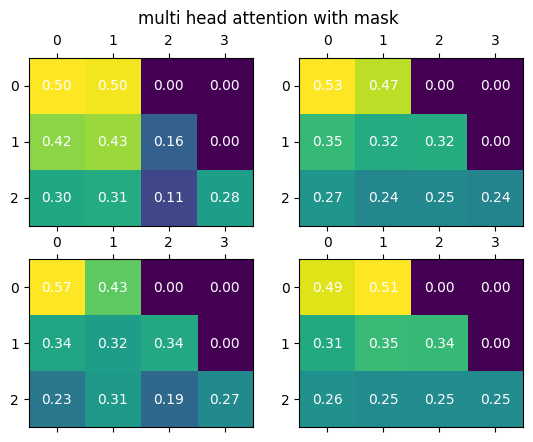

In [39]:
print('-'*50)
# mask
mask = torch.Tensor([[0, 0, 1, 1], [0, 0, 0, 1], [0, 0, 0, 0]]).reshape(1, 1, 3, 4) #手工构造mask
outputs_masked = mha(query, key_value, key_value, mask)

fig, axis = plt.subplots(*outputs_masked.attn_scores.shape[:2])
for i in range(query.shape[0]):
    for j in range(outputs_masked.attn_scores.shape[1]):
        axis[i, j].matshow(outputs_masked.attn_scores[i, j].detach().numpy())
        for x in range(outputs_masked.attn_scores.shape[2]):
            for y in range(outputs_masked.attn_scores.shape[3]):
                axis[i, j].text(y, x, f"{outputs_masked.attn_scores[i, j, x, y]:.2f}", ha="center", va="center", color="w")
fig.suptitle("multi head attention with mask")
plt.show()

#### Transformer-Block

In [40]:
# 通过使用 @dataclass 装饰器，Python 会自动为该类生成一些方法，如 __init__()、__repr__() 和 __eq__() 等，这些方法可以使类的使用更加方便。
@dataclass
class TransformerBlockOutput:
# hidden_states: Tensor：用于存储某个块产生的隐藏状态。
# self_attn_scores: Tensor：包含了自注意力机制（self-attention）所计算得到的注意力分数。
# cross_attn_scores: Optional[Tensor] = None：是一个可选字段，存储了交叉注意力（cross-attention）计算得到的注意力分数。这里的 Optional 表示这个字段可以是 Tensor 类型，也可以是 None。
    hidden_states: Tensor
    self_attn_scores: Tensor
    cross_attn_scores: Optional[Tensor] = None

class TransformerBlock(nn.Module):
    def __init__(self, config, add_cross_attention=False):
        super().__init__()
        # hyper params
        self.hidden_size = config["d_model"]
        self.num_heads = config["num_heads"]
        dropout_rate = config["dropout"]
        ffn_dim = config["dim_feedforward"]
        eps = config["layer_norm_eps"] # 层归一化的epsilon值

        # self-attention
        self.self_atten = MultiHeadAttention(config) # 多头注意力
        self.self_ln = nn.LayerNorm(self.hidden_size, eps=eps) #层归一化(层标准化)
        self.self_dropout = nn.Dropout(dropout_rate)

        # cross-attention，交叉注意力，decoder中使用,因此额外做一个判断
        if add_cross_attention:
            self.cross_atten = MultiHeadAttention(config)
            self.cross_ln = nn.LayerNorm(self.hidden_size, eps=eps)
            self.cross_dropout = nn.Dropout(dropout_rate)
        else:
            self.cross_atten = None

        # FFN,前馈神经网络
        self.ffn = nn.Sequential(
            nn.Linear(self.hidden_size, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, self.hidden_size),
        )
        self.ffn_ln = nn.LayerNorm(self.hidden_size, eps=eps)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(
        self,
        hidden_states,
        attn_mask=None,
        encoder_outputs=None,
        cross_attn_mask=None,
    ):
        # self-attention,自注意力
        self_atten_output = self.self_atten(
            hidden_states, hidden_states, hidden_states, attn_mask
        )
        self_embeds = self.self_ln(
            hidden_states + self.self_dropout(self_atten_output.hidden_states)
        ) #多头注意力进行dropout，然后和原始输入进行残差连接，然后进行层归一化

        # cross-attention，交叉注意力
        if self.cross_atten is not None:
            assert encoder_outputs is not None
            cross_atten_output = self.cross_atten(
                self_embeds, encoder_outputs, encoder_outputs, cross_attn_mask
            ) #query是self_embeds，key和value都是encoder_outputs
            cross_embeds = self.cross_ln(
                self_embeds + self.cross_dropout(cross_atten_output.hidden_states)
            ) # 交叉注意力进行dropout，然后和self_embeds进行残差连接，然后进行层归一化

        # FFN
        embeds = cross_embeds if self.cross_atten is not None else self_embeds # 如果有交叉注意力，则使用交叉注意力的输出作为FFN的输入；否则，使用self_embeds作为FFN的输入
        ffn_output = self.ffn(embeds) # 前馈神经网络
        embeds = self.ffn_ln(embeds + self.ffn_dropout(ffn_output)) # 前馈神经网络进行dropout，然后和原始输入进行残差连接，然后进行层归一化

        return TransformerBlockOutput(
            hidden_states=embeds,
            self_attn_scores=self_atten_output.attn_scores,
            cross_attn_scores=cross_atten_output.attn_scores
            if self.cross_atten is not None
            else None,
        )

#### Encoder

In [41]:
from typing import List

@dataclass
class TransformerEncoderOutput:
    last_hidden_states: Tensor
    attn_scores: List[Tensor]

# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.num_layers = config["num_encoder_layers"]

        # layers,仅仅是一个模块的列表，它本身没有定义前向传递（forward pass）过程。你需要在 forward 方法中明确地定义如何使用这些模块。
        self.layers = nn.ModuleList(
            [TransformerBlock(config) for _ in range(self.num_layers)]
        )

    def forward(
        self, encoder_inputs_embeds, attn_mask=None
    ) -> TransformerEncoderOutput:
        attn_scores = [] # 存储每个层的注意力分数
        embeds = encoder_inputs_embeds # 输入的嵌入向量作为第一层的输入(embedding+位置编码)
        for layer in self.layers:
            block_outputs = layer(embeds, attn_mask=attn_mask)
            embeds = block_outputs.hidden_states #上一层的输出作为下一层的输入
            # 在每个层的输出中，提取了隐藏状态 block_outputs.hidden_states，并将对应的注意力分数 block_outputs.self_attn_scores 添加到列表 attn_scores 中。
            attn_scores.append(block_outputs.self_attn_scores) # 存储每个层的注意力分数,用于画图

        return TransformerEncoderOutput(
            last_hidden_states=embeds, attn_scores=attn_scores
        )



#### Decoder

In [21]:
@dataclass
class TransformerDecoderOutput:
    last_hidden_states: Tensor
    self_attn_scores: List[Tensor]
    cross_attn_scores: List[Tensor]


class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.num_layers = config["num_decoder_layers"]

        # layers
        self.layers = nn.ModuleList(
            [
                TransformerBlock(config, add_cross_attention=True)
                for _ in range(self.num_layers)
            ]
        )

    def forward(
        self,
        decoder_inputs_embeds,
        encoder_outputs,
        attn_mask=None,
        cross_attn_mask=None,
    ) -> TransformerDecoderOutput:
        self_attn_scores = [] # 存储每个层的自注意力分数
        cross_attn_scores = [] # 存储每个层的交叉注意力分数
        embeds = decoder_inputs_embeds # 输入的嵌入向量作为第一层的输入(embedding+位置编码)
        for layer in self.layers:
            block_outputs = layer(
                embeds,
                attn_mask=attn_mask, # 自注意力的mask
                encoder_outputs=encoder_outputs,
                cross_attn_mask=cross_attn_mask, # 交叉注意力的mask
            )
            embeds = block_outputs.hidden_states # 上一层的输出作为下一层的输入
            self_attn_scores.append(block_outputs.self_attn_scores) # 存储每个层的自注意力分数
            cross_attn_scores.append(block_outputs.cross_attn_scores) # 存储每个层的交叉注意力分数

        return TransformerDecoderOutput(
            last_hidden_states=embeds,
            self_attn_scores=self_attn_scores,
            cross_attn_scores=cross_attn_scores,
        )


#### mask

- mask实际上大类上只有两种
    1. `padding_mask`：mask掉`pad_idx`，不计算损失
    2. `attention_mask`：mask掉`pad_idx`，不计算注意力分数
- Decoder的`attention_mask`和Encoder有一定的区别：
    - Encoder可以同时看见序列所有信息，故只mask掉`pad_idx`
    - Decoder只能看到在自身之前的序列的信息，故要额外mask掉自身之后的序列

In [22]:
(torch.triu(torch.ones(5, 5)) == 0).transpose(-1,-2)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

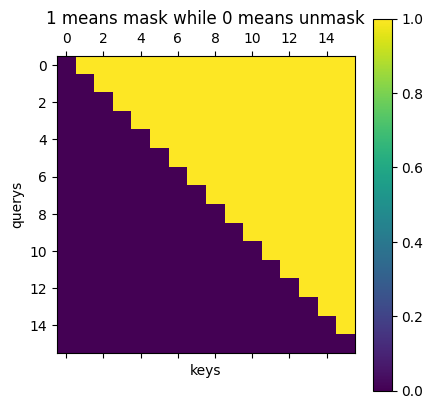

In [23]:

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """
    Generate a square mask for the sequence. The masked positions are filled with True.
        Unmasked positions are filled with False.
    """
    # torch.ones(sz, sz): 创建一个全为 1 的 sz × sz 的矩阵。
    # torch.triu(...): 使用 triu 函数取得矩阵的上三角部分，将主对角线以下部分置零。
    mask = (torch.triu(torch.ones(sz, sz)) == 0).transpose(-1, -2).bool()
    # mask = torch.triu(torch.ones(sz, sz))
    return mask


plt.matshow(generate_square_subsequent_mask(16))
plt.colorbar()
plt.xlabel("keys")
plt.ylabel("querys")
plt.title("1 means mask while 0 means unmask")
plt.show()

['[BOS]', '[UNK]', '[UNK]', 'brown', '[UNK]', 'jumps', 'over', 'the', '[UNK]', 'dog', '.', '[EOS]']


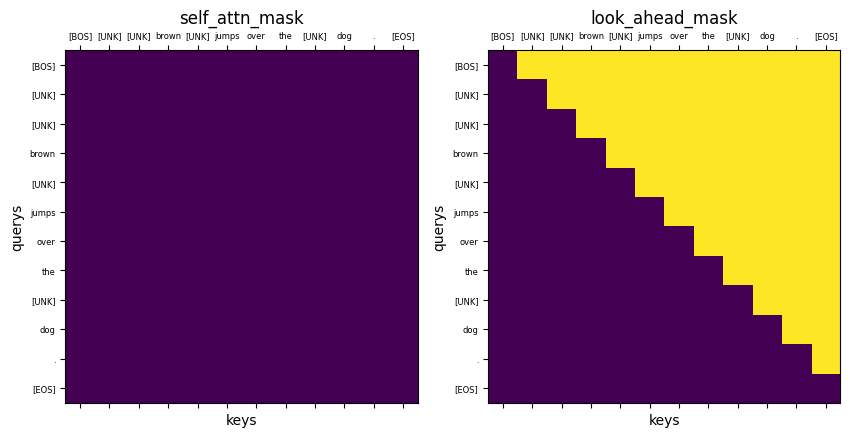

--------------------------------------------------
['[BOS]', '[UNK]', 'does', 'the', '[UNK]', 'say', '?', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


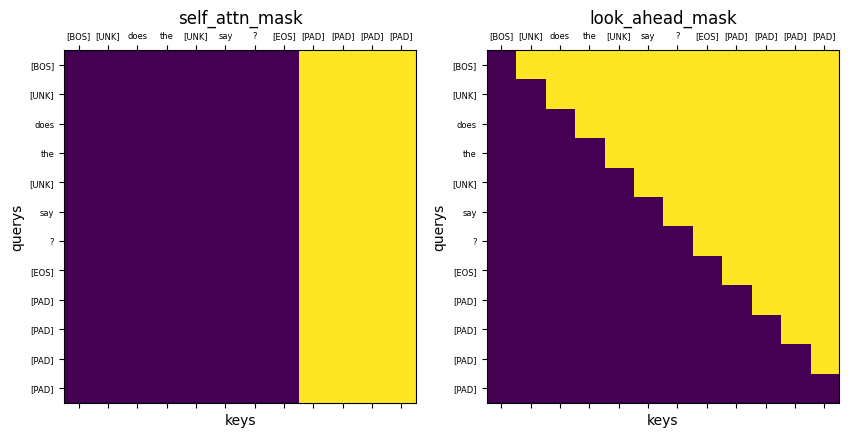

--------------------------------------------------


In [24]:
#通过下面代码查看mask的效果
inputs_words = ["The quick brown fox jumps over the lazy dog .", "What does the fox say ?"]

inputs_ids, input_mask = tokenizer.encode([w.split() for w in inputs_words], return_mask=True)
for i in range(len(inputs_words)):
    decode_text = tokenizer.decode(inputs_ids[i: i+1].tolist(), remove_bos=False, remove_eos=False, remove_pad=False, split=True)[0]
    print(decode_text)
    self_attn_mask  = input_mask[i].reshape(1, -1).repeat_interleave(inputs_ids.shape[-1], dim=0)
    look_ahead_mask = generate_square_subsequent_mask(inputs_ids.shape[-1])

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].matshow(self_attn_mask)
    axs[0].set_title("self_attn_mask")
    axs[0].set_yticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[0].set_ylabel("querys")
    axs[0].set_xticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[0].set_xlabel("keys")
    axs[1].matshow(look_ahead_mask)
    axs[1].set_title("look_ahead_mask")
    axs[1].set_yticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[1].set_ylabel("querys")
    axs[1].set_xticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[1].set_xlabel("keys")
    plt.show()
    print('-'*50)

#### Transformer Model

In [25]:
@dataclass
class TransformerOutput:
    logits: Tensor
    encoder_last_hidden_states: Tensor
    encoder_attn_scores: List[Tensor]
    decoder_last_hidden_states: Tensor
    decoder_self_attn_scores: List[Tensor]
    decoder_cross_attn_scores: List[Tensor]
    preds: Optional[Tensor] = None

class TransformerModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.hidden_size = config["d_model"]
        self.num_encoder_layers = config["num_encoder_layers"]
        self.num_decoder_layers = config["num_decoder_layers"]
        self.pad_idx = config["pad_idx"]
        self.bos_idx = config["bos_idx"]
        self.eos_idx = config["eos_idx"]
        self.vocab_size = config["vocab_size"]
        self.dropout_rate = config["dropout"]
        self.max_length = config["max_length"]
        self.share = config["share_embedding"]

        # layers
        self.src_embedding = TransformerEmbedding(config) # 输入的嵌入层
        if self.share:#如果共享词嵌入，则使用src_embedding作为trg_embedding
            self.trg_embedding = self.src_embedding #源和目标的嵌入层相同，共享参数，节省内存
            self.linear = lambda x: torch.matmul(
                x, self.trg_embedding.get_word_embedding_weights().T
            ) # 输出层，共享参数，直接拿原有embedding矩阵的转置，节省内存
        else:
            self.trg_embedding = TransformerEmbedding(config) #decoder模块的嵌入层
            self.linear = nn.Linear(self.hidden_size, self.vocab_size) # 输出层

        self.encoder = TransformerEncoder(config)
        self.decoder = TransformerDecoder(config)

        # init weights
        self._init_weights()

    def _init_weights(self):
        """使用 xavier 均匀分布来初始化权重"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        """
        Generate a square mask for the sequence. The masked positions are filled with True.
            Unmasked positions are filled with False.为了生成斜三角的mask
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 0).transpose(-1, -2).bool()

        return mask

    def forward(
        self, encoder_inputs, decoder_inputs, encoder_inputs_mask=None
    ) -> TransformerOutput:
        # encoder_inputs: [batch_size, src_len]
        # decoder_inputs: [batch_size, trg_len]
        # encoder_inputs_mask: [batch_size, src_len]
        if encoder_inputs_mask is None:
            encoder_inputs_mask = encoder_inputs.eq(self.pad_idx) # [batch_size, src_len]
        encoder_inputs_mask = encoder_inputs_mask.unsqueeze(1).unsqueeze(
            2
        )  # [batch_size, 1, 1, src_len],用于encoder的自注意力
        look_ahead_mask = self.generate_square_subsequent_mask(decoder_inputs.shape[1])
        look_ahead_mask = (
            look_ahead_mask.unsqueeze(0).unsqueeze(0).to(decoder_inputs.device)
        )  # [1, 1, trg_len, trg_len],用于decoder的自注意力
        #增加decoder_inputs_mask和look_ahead_mask进行组合
        decoder_inputs_mask = decoder_inputs.eq(self.pad_idx) # [batch_size, trg_len]
        # print(decoder_inputs_mask.shape)
        decoder_inputs_mask = decoder_inputs_mask.unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, trg_len]
        # print(decoder_inputs_mask.shape)
        decoder_inputs_mask = decoder_inputs_mask + look_ahead_mask # [batch_size, 1, 1, trg_len]与[1, 1, trg_len, trg_len]相加，得到decoder的自注意力mask

        # encoding
        encoder_inputs_embeds = self.src_embedding(encoder_inputs)
        encoder_outputs = self.encoder(encoder_inputs_embeds, encoder_inputs_mask) #encoder_inputs_mask用于encoder的自注意力,广播去做计算

        # decoding
        decoder_inputs_embeds = self.trg_embedding(decoder_inputs)
        decoder_outputs = self.decoder(
            decoder_inputs_embeds=decoder_inputs_embeds,
            encoder_outputs=encoder_outputs.last_hidden_states,
            attn_mask=decoder_inputs_mask, #用于decoder的自注意力,广播去做计算
            cross_attn_mask=encoder_inputs_mask,#用于decoder的交叉注意力,广播去做计算
        )

        logits = self.linear(decoder_outputs.last_hidden_states)

        return TransformerOutput(
            logits=logits,
            encoder_last_hidden_states=encoder_outputs.last_hidden_states,
            encoder_attn_scores=encoder_outputs.attn_scores,
            decoder_last_hidden_states=decoder_outputs.last_hidden_states,
            decoder_self_attn_scores=decoder_outputs.self_attn_scores,
            decoder_cross_attn_scores=decoder_outputs.cross_attn_scores,
        )

    @torch.no_grad()
    def infer(self, encoder_inputs, encoder_inputs_mask=None) -> Tensor:
        # assert len(encoder_inputs.shape) == 2 and encoder_inputs.shape[0] == 1
        if encoder_inputs_mask is None:#应对多个样本同时进行推理
            encoder_inputs_mask = encoder_inputs.eq(self.pad_idx)
        encoder_inputs_mask = encoder_inputs_mask.unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, src_len],[1,src_len]相加时，会自动广播到[batch_size,1,src_len,src_len]
        look_ahead_mask = self.generate_square_subsequent_mask(self.max_length)
        look_ahead_mask = (
            look_ahead_mask.unsqueeze(0).unsqueeze(0).to(encoder_inputs.device)
        )  # [1, 1, trg_len, trg_len]

        # encoding
        encoder_inputs_embeds = self.src_embedding(encoder_inputs)
        encoder_outputs = self.encoder(encoder_inputs_embeds) #因为只支持单样本预测，没有paddings，所以不需要mask

        # decoding
        decoder_inputs = torch.Tensor([self.bos_idx] * encoder_inputs.shape[0]).reshape(-1, 1).long().to(device=encoder_inputs.device)
        for cur_len in tqdm(range(1, self.max_length + 1)):
            decoder_inputs_embeds = self.trg_embedding(decoder_inputs)
            decoder_outputs = self.decoder(
                decoder_inputs_embeds=decoder_inputs_embeds,
                encoder_outputs=encoder_outputs.last_hidden_states,
                attn_mask=look_ahead_mask[:, :, :cur_len, :cur_len],#decoder的自注意力mask
            )

            logits = self.linear(decoder_outputs.last_hidden_states)
            next_token = logits.argmax(dim=-1)[:, -1:] #通过最大下标确定类别，[:, -1:]表示取最后一个结果
            decoder_inputs = torch.cat([decoder_inputs, next_token], dim=-1) #预测输出拼接到输入中

            if all((decoder_inputs == self.eos_idx).sum(dim=-1) > 0):
                break

        return TransformerOutput(
            preds=decoder_inputs[:, 1:],
            logits=logits,
            encoder_last_hidden_states=encoder_outputs.last_hidden_states,
            encoder_attn_scores=encoder_outputs.attn_scores,
            decoder_last_hidden_states=decoder_outputs.last_hidden_states,
            decoder_self_attn_scores=decoder_outputs.self_attn_scores,
            decoder_cross_attn_scores=decoder_outputs.cross_attn_scores,
        )

## 训练

### 损失函数

In [26]:
class CrossEntropyWithPadding:
    def __init__(self, config):
        self.label_smoothing = config["label_smoothing"]

    def __call__(self, logits, labels, padding_mask=None):
        # logits.shape = [batch size, sequence length, num of classes]
        # labels.shape = [batch size, sequence length]
        # padding_mask.shape = [batch size, sequence length]
        bs, seq_len, nc = logits.shape
        loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduce=False, label_smoothing=self.label_smoothing) #label_smoothing表示随机将一个类别的概率设置为0.1，使得模型更加关注其他类别
        if padding_mask is None:
            loss = loss.mean()
        else:
            padding_mask = 1 - padding_mask.reshape(-1) #将padding_mask reshape成一维张量，mask部分为0，非mask部分为1
            loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()

        return loss


### 学习率衰减

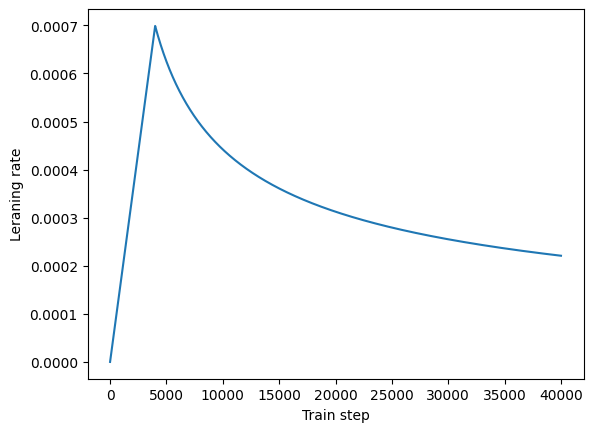

In [27]:
# NoamDecayScheduler 是一个自定义或外部定义的学习率衰减调度器类。它需要接收配置 config 作为参数，可能实现了特定的学习率衰减方案
class NoamDecayScheduler:
    def __init__(self, config):
        self.d_model = config["d_model"]
        self.warmup_steps = config["warmup_steps"]

    def __call__(self, step):
        step += 1
        arg1 = step ** (-0.5)
        arg2 = step * (self.warmup_steps ** (-1.5))

        arg3 = self.d_model ** (-0.5)

        return arg3 * np.minimum(arg1, arg2)


temp_learning_rate_schedule = NoamDecayScheduler({"d_model": 512, "warmup_steps": 4000})
#下面是学习率的设计图
plt.plot(temp_learning_rate_schedule(np.arange(0, 40000)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")
plt.show()


### 优化器

In [28]:
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import Adam

def get_optimizer(model, config):
    base_lr = 0.1
    beta1 = config["beta1"] # Adam 的 beta1
    beta2 = config["beta2"] # Adam 的 beta2
    eps = config["eps"]
    optimizer = Adam(model.parameters(), lr=base_lr, betas=(beta1, beta2), eps=eps)
    lr_scheduler = NoamDecayScheduler(config) #config是一个字典，包含了学习率衰减的参数
    # 使用 LambdaLR 调度器，它可以根据给定的函数 lr_lambda 调整学习率。这里将 lr_scheduler 作为函数传递给 LambdaLR，它包含了特定于模型或任务的学习率调度规则
    scheduler = LambdaLR(optimizer, lr_lambda=lr_scheduler)
    return optimizer, scheduler

### Callback

In [29]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


In [30]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [31]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


### training & valuating

In [32]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for batch in dataloader:
        encoder_inputs = batch["encoder_inputs"]
        encoder_inputs_mask = batch["encoder_inputs_mask"]
        decoder_inputs = batch["decoder_inputs"]
        decoder_labels = batch["decoder_labels"]
        decoder_labels_mask = batch["decoder_labels_mask"]

        # 前向计算
        outputs = model(
            encoder_inputs=encoder_inputs,
            decoder_inputs=decoder_inputs,
            encoder_inputs_mask=encoder_inputs_mask
            )
        logits = outputs.logits
        loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)         # 验证集损失
        loss_list.append(loss.cpu().item())

    return np.mean(loss_list)


In [33]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    scheduler=None,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 1
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for batch in train_loader:
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                decoder_labels_mask = batch["decoder_labels_mask"]
                # 梯度清空
                optimizer.zero_grad()

                # 前向计算
                outputs = model(
                    encoder_inputs=encoder_inputs,
                    decoder_inputs=decoder_inputs,
                    encoder_inputs_mask=encoder_inputs_mask
                    )
                logits = outputs.logits
                loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)

                # 梯度回传
                loss.backward()

                # 调整优化器，包括学习率的变动等
                optimizer.step()
                if scheduler is not None:
                    scheduler.step() # 更新学习率

                loss = loss.cpu().item()
                # record
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    cur_lr = optimizer.param_groups[0]["lr"] if scheduler is None else scheduler.get_last_lr()[0]
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            lr=cur_lr,
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
            pbar.set_postfix({"epoch": epoch_id, "loss": loss, "val_loss": val_loss})

    return record_dict


In [34]:
config = {
    "bos_idx": 1,
    "eos_idx": 3,
    "pad_idx": 0,
    "vocab_size": len(word2idx),
    "max_length": 128,
    "d_model": 512,
    "dim_feedforward": 2048,
    "dropout": 0.1,
    "layer_norm_eps": 1e-6, # 层归一化的 epsilon, 防止除零错误
    "num_heads": 8,
    "num_decoder_layers": 6,
    "num_encoder_layers": 6,
    "label_smoothing": 0.1,
    "beta1": 0.9,
    "beta2": 0.98,
    "eps": 1e-9,
    "warmup_steps": 4_000,
    "share_embedding": False, # 是否共享词向量
    }


def get_dl(dataset, batch_size, shuffle=True):
    sampler = TransformerBatchSampler(dataset, batch_size=batch_size, shuffle_batch=shuffle)
    sample_dl = DataLoader(dataset, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer))
    return sample_dl

# dataset
train_ds = LangPairDataset("train", max_length=config["max_length"])
val_ds = LangPairDataset("val", max_length=config["max_length"])
# tokenizer
tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word, max_length=config["max_length"])
batch_size = 2048
# dataloader
train_dl = get_dl(train_ds, batch_size=batch_size, shuffle=True)
val_dl = get_dl(val_ds, batch_size=batch_size, shuffle=False)

load train dataset from wmt16/.cache/de2en_train_128.npy
load val dataset from wmt16/.cache/de2en_val_128.npy


In [ ]:
config

{'bos_idx': 1,
 'eos_idx': 3,
 'pad_idx': 0,
 'vocab_size': 9718,
 'max_length': 128,
 'd_model': 512,
 'dim_feedforward': 2048,
 'dropout': 0.1,
 'layer_norm_eps': 1e-06,
 'num_heads': 8,
 'num_decoder_layers': 6,
 'num_encoder_layers': 6,
 'label_smoothing': 0.1,
 'beta1': 0.9,
 'beta2': 0.98,
 'eps': 1e-09,
 'warmup_steps': 4000,
 'share_embedding': False}

In [ ]:
epoch = 20

# model
model = TransformerModel(config)
# 1. 定义损失函数 采用交叉熵损失
loss_fct = CrossEntropyWithPadding(config)
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer, scheduler = get_optimizer(model, config)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
exp_name = "translate-transformer-{}".format("share" if config["share_embedding"] else "not-share")
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"checkpoints/{exp_name}", save_step=500, save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=8)

model = model.to(device)

record = training(
    model,
    train_dl,
    val_dl,
    epoch,
    loss_fct,
    optimizer,
    scheduler,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=None,
    eval_step=500
    )

# Training took 3.5 days on 8 P100 GPUs
# We trained the base models for a total of 100,000 steps or 12 hours. For our big models,(described on the bottom line of table 3), step time was 1.0 seconds. The big models were trained for 300,000 steps (3.5 days).

  0%|          | 0/280 [00:00<?, ?it/s]

## 推理

- 翻译项目的评估指标一般是BLEU4，感兴趣的同学自行了解并实现
- 接下来进行翻译推理，并作出注意力的热度图

In [42]:
# !pip install Cython  # if failed to install fastBPE, try this line
!pip install fastBPE #分词使用
# 在 Windows 系统上并没有 sys/mman.h 文件

  Preparing metadata (setup.py) ... done
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp310-cp310-linux_x86_64.whl size=806588 sha256=b77d4a1091f1aa812ca7c62cb09e4397a6cb8ae13061a3c1aeb5bc104e3d8dc7
  Stored in directory: /root/.cache/pip/wheels/13/5d/b9/4b8897941ebc9e8c6cc3f3ffd3ea5115731754269205098754
Successfully built fastBPE


In [ ]:
exp_name

'translate-transformer-not-share'

In [35]:
import torch

state_dict = torch.load(f"best.ckpt", map_location="cpu")

# state_dict1 = torch.load("epoch125-step132426.ckpt", map_location="cpu")
# state_dict = state_dict1["state_dict"]

# update keys by dropping `model`
for key in list(state_dict):
    state_dict[key.replace("model.", "")] = state_dict.pop(key)


In [36]:
!pip install nltk

In [55]:
!rm -r wmt16/.cache

In [38]:
tokenizer.decode([[   5,   16,    6,   23,  150,   80, 8248,   35,  232,    4,    3]])

['a man in an orange hat starring at something .']

In [46]:
from nltk.translate.bleu_score import sentence_bleu
# load checkpoints
model = TransformerModel(config)
model.load_state_dict(state_dict)

loss_fct = CrossEntropyWithPadding(config)
# from dataset import LangPairDataset
test_ds = LangPairDataset("test", max_length=128, data_dir="./wmt16")
test_dl = DataLoader(test_ds, batch_size=1, collate_fn=partial(collate_fct, tokenizer=tokenizer))

model = model.to(device)
model.eval()
collect = {}
loss_collect = []

predictions = []
answers = []
# 初始化BLEU分数列表
bleu_scores = []
for idx, batch in tqdm(enumerate(test_dl)):
    encoder_inputs = batch["encoder_inputs"]
    encoder_inputs_mask = batch["encoder_inputs_mask"]
    decoder_inputs = batch["decoder_inputs"]
    decoder_labels = batch["decoder_labels"]
    # print(decoder_labels.cpu())
    # decoder_labels1=tokenizer.decode(decoder_labels.cpu().numpy())
    # print(decoder_labels1)
    # 前向计算
    outputs = model(
        encoder_inputs=encoder_inputs,
        decoder_inputs=decoder_inputs,
        encoder_inputs_mask=encoder_inputs_mask
        )
    loss = loss_fct(outputs.logits, decoder_labels)         # 验证集损失

    # print(outputs.logits.shape, decoder_labels.shape)

    # loss = loss_fct(outputs.logits[:, :decoder_labels.shape[1]], decoder_labels)         # 验证集损失
    # outputs = model.infer(encoder_inputs=encoder_inputs)
    # print(outputs.logits.shape)
    preds = outputs.logits.argmax(dim=-1) # 预测结果，[1,seq_len]
    # print(preds.shape)
    #把preds转为英文单词
    preds = tokenizer.decode(preds.cpu().numpy()) #['预测句子']
    # predictions.append(preds)
    # print(preds)
    #把decoder_labels转为英文单词
    decoder_labels = tokenizer.decode(decoder_labels.cpu().numpy()) #['标签句子']
    # answers.append(decoder_labels)
    # print(decoder_labels)
    belu=sentence_bleu([decoder_labels[0].split()],preds[0].split(),weights=(1, 0, 0, 0))
    bleu_scores.append(belu)
    collect[idx] = {"loss": loss.item(), "src_inputs": encoder_inputs, "trg_inputs": decoder_inputs, "mask": encoder_inputs_mask, "trg_labels": decoder_labels, "preds": preds}
    loss_collect.append(loss.item())
    # break

# sort collect by value
collect = sorted(collect.items(), key=lambda x: x[1]["loss"])
print(f"testing loss: {np.array(loss_collect).mean()}")
sum(bleu_scores) / len(bleu_scores)

load test dataset from wmt16/.cache/de2en_test_128.npy


0it [00:00, ?it/s]

testing loss: 3.258438676626829


0.5708733100076216

  0%|          | 0/128 [00:00<?, ?it/s]

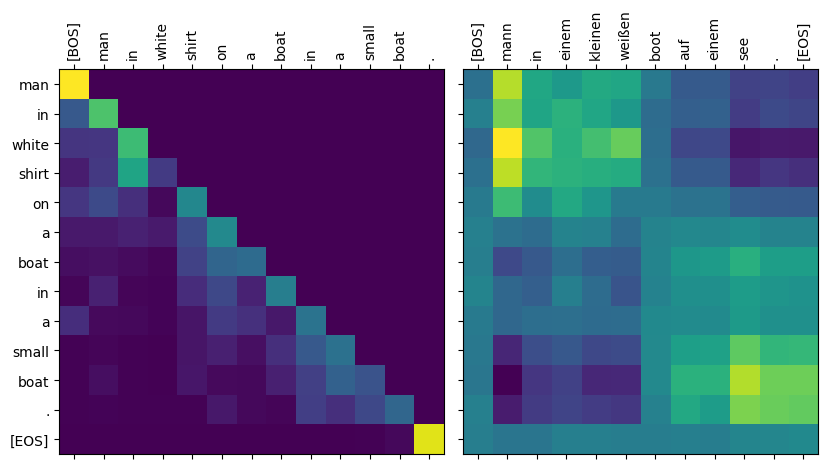

['man in white shirt on a boat in a small boat.']

In [41]:
import re
from fastBPE import fastBPE
from sacremoses import MosesDetokenizer, MosesTokenizer

# `MosesTokenizer` 和 `MosesDetokenizer` 是来自 `sacremoses` 库的工具，用于自然语言处理中的分词（Tokenization）和去标记化（Detokenization）。这些工具主要用于对文本进行预处理和后处理，通常在处理自然语言处理任务时会用到。
#
# ### MosesTokenizer：
# - **作用**：将原始文本分割成单词和标点符号。
# - **特点**：基于 Moses 翻译工具中使用的分词方法。
# - **功能**：
#   - 将句子分割成单词和标点符号。
#   - 处理缩写、连字符、标点等特殊情况。
#   - 对文本进行标记化，方便后续处理。
#
# ### MosesDetokenizer：
# - **作用**：将分词后的文本重新组合成原始的句子。
# - **特点**：用于对分词后的文本进行还原，使其恢复为可读的句子形式。
# - **功能**：
#   - 将分词后的单词和标点符号重新组合成句子。
#   - 处理分词后的标点、缩写等情况，使得结果更加自然和可读。
#
# 这些工具通常在文本预处理和后处理过程中使用，对输入的文本进行标记化和去标记化，是一种常用的处理方式。在自然语言处理任务中，对文本进行正确的分词和还原是很重要的，而 `MosesTokenizer` 和 `MosesDetokenizer` 提供了方便、高效的工具来处理这些任务。

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.bpe = fastBPE("./wmt16/bpe.10000", "./wmt16/vocab")
        self.mose_tokenizer = MosesTokenizer(lang="de")
        self.mose_detokenizer = MosesDetokenizer(lang="en")
        self.model = model
        self.model.eval()
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        self.pattern = re.compile(r'(@@ )|(@@ ?$)')

    def draw_attention_map(self, attn_scores, cross_attn_scores, src_words_list, trg_words_list):
        """绘制注意力热力图
        attn_scores (numpy.ndarray): 表示自注意力机制（self-attention）分数。
        cross_attn_scores (numpy.ndarray): 表示交叉注意力机制的注意力分数。
        src_words_list (list): 源语言句子的单词列表。
        trg_words_list (list): 目标语言句子的单词列表。
        """
        assert len(attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, target sequence length], but got {attn_scores.shape}"
        attn_scores = attn_scores[:, :len(trg_words_list), :len(trg_words_list)]

        assert len(cross_attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, source sequence length], but got {cross_attn_scores.shape}"
        cross_attn_scores = cross_attn_scores[:, :len(trg_words_list), :len(src_words_list)]

        num_heads, trg_len, src_len = cross_attn_scores.shape

        fig = plt.figure(figsize=(10, 5), constrained_layout=True) # constrained_layout=True 自动调整子图参数，使之填充整个图像区域
        grid = plt.GridSpec(trg_len, trg_len + src_len, wspace=0.1, hspace=0.1)# wspace,hspace 控制子图之间的间距
        #下面是attn_scores的热力图
        self_map = fig.add_subplot(grid[:,:trg_len]) #  添加子图
        self_map.matshow(attn_scores.mean(dim=0), cmap='viridis') # 绘制热力图，cmap表示颜色,dim=0表示对第0维求均值
        self_map.set_yticks(range(trg_len), trg_words_list, fontsize=10)
        self_map.set_xticks(range(trg_len), ["[BOS]"] + trg_words_list[:-1], rotation=90)
        #下面是cross_attn_scores的热力图
        cross_map = fig.add_subplot(grid[:, trg_len:])
        cross_map.matshow(cross_attn_scores.mean(dim=0), cmap='viridis')
        cross_map.set_yticks(range(trg_len), [], fontsize=6)
        cross_map.set_xticks(range(src_len), src_words_list, rotation=90)

        plt.show()

    def draw_attention_maps(self, attn_scores, cross_attn_scores, src_words_list, trg_words_list, heads_list):
        """绘制注意力热力图

        Args:
            - scores (numpy.ndarray): shape = [source sequence length, target sequence length]
        """
        assert len(attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, target sequence length], but got {attn_scores.shape}"
        attn_scores = attn_scores[:, :len(trg_words_list), :len(trg_words_list)]

        assert len(cross_attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, source sequence length], but got {cross_attn_scores.shape}"
        cross_attn_scores = cross_attn_scores[:, :len(trg_words_list), :len(src_words_list)]
        # cross_attn_scores = cross_attn_scores[:, :len(src_words_list), :len(src_words_list)]

        num_heads, trg_len, src_len = cross_attn_scores.shape
        fig, axes = plt.subplots(2, len(heads_list), figsize=(5 * len(heads_list), 10))
        for i, heads_idx in enumerate(heads_list):
            axes[0, i].matshow(attn_scores[heads_idx], cmap='viridis')
            axes[0, i].set_yticks(range(trg_len), trg_words_list)
            axes[0, i].set_xticks(range(trg_len), ["[BOS]"] + trg_words_list[:-1], rotation=90)
            axes[0, i].set_title(f"head {heads_idx}")
            axes[1, i].matshow(cross_attn_scores[heads_idx], cmap='viridis')
            axes[1, i].set_yticks(range(trg_len), trg_words_list)
            axes[1, i].set_xticks(range(src_len), src_words_list, rotation=90)
            axes[1, i].set_title(f"head {heads_idx}")

        plt.show()


    def __call__(self, sentence_list, heads_list=None, layer_idx=-1):
        # 将输入句子列表转换为小写，并使用 MosesTokenizer 进行分词处理。
        sentence_list = [" ".join(self.mose_tokenizer.tokenize(s.lower())) for s in sentence_list]
        # 将分词后的结果进行 BPE 编码，得到 tokens_list。
        tokens_list = [s.split() for s in self.bpe.apply(sentence_list)]
        # 使用 src_tokenizer 对 tokens_list 进行编码，同时添加起始标记 ([BOS]) 和结束标记 ([EOS])。
        encoder_input, attn_mask = self.src_tokenizer.encode(
            tokens_list,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            )
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64)
        # 使用模型的 infer 方法对编码器输入进行推理，得到输出结果 outputs
        outputs = model.infer(encoder_inputs=encoder_input, encoder_inputs_mask=attn_mask)

        preds = outputs.preds.numpy()
        # 使用目标语言的 trg_tokenizer 对预测序列进行解码，得到解码后的目标语言句子列表 trg_decoded。
        trg_decoded = self.trg_tokenizer.decode(preds, split=True, remove_eos=False, remove_bos=False, remove_pad=False)
        # 使用源语言的 src_tokenizer 对编码器输入进行解码，得到解码后的源语言句子列表 src_decoded。为下面绘制热力图做准备。
        src_decoded = self.src_tokenizer.decode(
            encoder_input.numpy(),
            split=True,
            remove_bos=False,
            remove_eos=False
            )

        # post processed attn scores
        # outputs.decoder_attentions[-1]  # the last layer of self-attention scores

        # draw the attention map of the last decoder block
        for attn_score, cross_attn_score, src, trg in zip(
            outputs.decoder_self_attn_scores[layer_idx], outputs.decoder_cross_attn_scores[layer_idx], src_decoded, trg_decoded):
            if heads_list is None:# 如果没有指定heads_list，就画单个热力图
                self.draw_attention_map(
                    attn_score,
                    cross_attn_score,
                    src,
                    trg,
                )
            else:# 如果指定了heads_list，就画多个热力图
                self.draw_attention_maps(
                    attn_score,
                    cross_attn_score,
                    src,
                    trg,
                    heads_list=heads_list,
                    )
        return [self.mose_detokenizer.tokenize(self.pattern.sub("", s).split()) for s in self.trg_tokenizer.decode(preds)] #将解码后的目标语言句子列表返回，并使用 mose_detokenizer 进行去标记化，最终得到翻译后的结果。


# sentence_list = [
#     "Mann in einem kleinen weißen Boot auf einem See.",  # Man in a small white boat on a lake.
#     "Ein Mann mit einem Eimer und ein Mädchen mit einem Hut am Strand.", # A man with a bucket and a girl in a hat on the beach.
#     "Drei Männer auf Pferden während eines Rennens.",  # Three men on horses during a race.
#     "Ein Mann und eine Frau essen zu Abend",  # 一个男人和一个女人在吃晚餐
# ]
sentence_list = [
    "Mann in einem kleinen weißen Boot auf einem See.",  # Man in a small white boat on a lake.
    # "Ein Mann mit einem Eimer und ein Mädchen mit einem Hut am Strand.", # A man with a bucket and a girl in a hat on the beach.
    # "Drei Männer auf Pferden während eines Rennens.",  # Three men on horses during a race.
    # "Ein Mann und eine Frau essen zu Abend",  # 一个男人和一个女人在吃晚餐
]

# load checkpoints
model = TransformerModel(config)
model.load_state_dict(state_dict)
translator = Translator(model.cpu(), tokenizer, tokenizer)
translator(
    sentence_list,
    layer_idx=-1,
    # heads_list=[0, 1, 2, 3, 4, 5, 6, 7]
    )


In [ ]:
!ls checkpoints

translate-transformer-not-share


In [ ]:
# prompt: 把best.ckpt复制到云盘内

!cp -r checkpoints/translate-transformer-not-share/best.ckpt /content/drive/MyDrive/transformer-de-en
